In [61]:
#Imports
import numpy as np
import h5py as h5
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 12

In [62]:
#datasets
data_path = '/projects/nikhil/ADNI_prediction/input_datasets/'

#input data
train_val_file = data_path + 'cli_ct_seg_fused_train_plus_val.pkl'
test_file = '/projects/francisco/data/ADNI/cli_ct_seg_fused_test.pkl'

#k-fold indices (from a saved file)
kf_file = data_path + 'cli_ct_train_valid_KFold_idx.pkl'


In [63]:
#Grab CV data with specific feature columes (independent vars) and specific clinical scale (dependent var)
def load_CV_data(in_file, kf_file, clinical_scale, feature_cols):
    data = pd.read_pickle(in_file)
    all_regex = '|'.join(['^{}'.format(var) for var in feature_cols + clinical_scale])
    all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
    data_trunc = data.filter(regex=all_regex)
    data_trunc = data_trunc.dropna(how='any')
    X = np.asarray(data_trunc.filter(regex=all_vars), dtype=float)
    y = np.asarray(data_trunc[clinical_scale], dtype=float)
    kf = pickle.load( open(kf_file, "rb" ) )
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])

    var_names = data_trunc.filter(regex=all_vars).columns
    
    # Return train and validation lists comprising all folds
    return {'X_train':X_train,'X_valid':X_valid,'y_train':y_train,'y_valid':y_valid}, var_names

#Load test data
def load_test_data(in_file, clinical_scale, feature_cols):
    data = pd.read_pickle(in_file)
    all_regex = '|'.join(['^{}'.format(var) for var in feature_cols + clinical_scale])
    all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
    data_trunc = data.filter(regex=all_regex)
    data_trunc = data_trunc.dropna(how='any')
    X = np.asarray(data_trunc.filter(regex=all_vars), dtype=float)
    y = np.asarray(data_trunc[clinical_scale], dtype=float)
    return {'X':X, 'y':y}
    

In [64]:
feature_cols = ['CT', 'L_HC_VOL','R_HC_VOL']
clinical_scale = ['ADAS13']

cv_data, var_names = load_CV_data(train_val_file,kf_file, clinical_scale, feature_cols)
test_data = load_test_data(test_file, clinical_scale, feature_cols)
print cv_data['X_train'][0].shape

(522, 76)


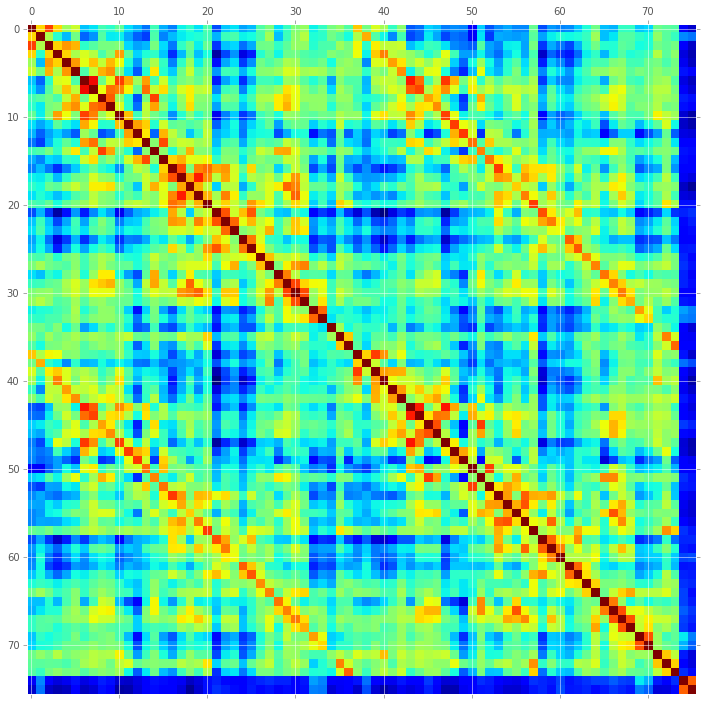

In [65]:
# Correlation matrix
data = pd.read_pickle(train_val_file)
all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
data_trunc = data.filter(regex=all_vars)
data_trunc = data_trunc.dropna(how='any')

plt.matshow(data_trunc.corr())




In [103]:
# Define a model

# The two independent vars are highly correlated, so an ordinary least squares regression may
# be the best idea: the model will be highly sensitive to random errors in the response var. See 
# https://en.wikipedia.org/wiki/Multicollinearity

# Space for hyperparam search
alphas=np.logspace(-5,5,num=100)

# We can instead try a ridge regression:
import scipy
from sklearn import linear_model
from sklearn.metrics import r2_score
BaseReg=linear_model.Ridge
    
class Regression(BaseReg):
    def __init__(self, alpha=0.1, normalize=False, fit_intercept=True):
        super(Regression, self).__init__(alpha=0.1, normalize=False, fit_intercept=True)
    

    def fit(self, X, y):
        self = super(Regression, self).fit(X,y)
        df = X.shape[0] - X.shape[1] - 1
        y_hat = self.predict(X)
        sse = np.sum(np.square(y - y_hat), axis=0)
        self.variance_y = sse/df
        self.variance_X = (np.matrix(X).T * np.matrix(X)).I
        self.zscores_ = self.coef_ / np.sqrt(self.variance_y * self.variance_X.diagonal())
        self.pvals_ = 1 - scipy.stats.t.cdf(abs(self.zscores_), df)
    
    def score(self, X, y):
        N, P = X.shape
        y_hat = self.predict(X)
        
        # R2 and adjusted R2:
        self.R2 = r2_score(y, y_hat)
        self.rmse = np.sqrt(mean_squared_error(y, y_hat))
        self.adj_R2 = self.R2 - (1 - self.R2) * ((N - 1) / (N - P - 1))
        
        self.var_y = np.var(y)
        
        self.ssm = np.sum(np.square(y_hat - y.mean()))
        self.sse = np.sum(np.square(y - y_hat))
        self.sst = np.sum(np.square(y - y.mean()))
        self.r = scipy.stats.pearsonr(y, y_hat)
        
        return self.R2
        

if BaseReg==linear_model.Ridge:
    reg = Regression(alpha=0.1, normalize=False, fit_intercept=True)
else:
    reg = Regression(normalize=False, fit_intercept=True)

In [104]:
X = cv_data['X_valid'][0]
N, P = X.shape
print N, P


59 76


In [105]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RandomizedLasso

# Cross-validation loop
stats = []
coefs = []
alphas = []
zscores = []
pvals = []
feat_scores = []
supports = []

for fold in range(len(cv_data['X_train'])):
    X = cv_data['X_train'][fold]
    y = cv_data['y_train'][fold].ravel()
    X_v = cv_data['X_valid'][fold]
    y_v = cv_data['y_valid'][fold].ravel()
        
    pipeline = Pipeline([
        ('selector', RandomizedLasso()),
        ('regressor', Regression())
    ])
    
    parameters = {
        'selector__n_resampling': [1000],
        'regressor__alpha': np.logspace(-3,3,15),
        'regressor__normalize': [False],
        'regressor__fit_intercept': [True],
    }

    grid_search = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1)

    grid_search.fit(X, y)
    
    cvsel = grid_search.best_estimator_.steps[0][1]
    supports.append(cvsel.get_support(indices=True))
    
    feat_scores.append(cvsel.scores_)
    cvreg = grid_search.best_estimator_.steps[1][1]
    y_hat = grid_search.predict(X)

    # validation:
    y_hat_v = grid_search.predict(X_v)
    grid_search.best_estimator_.score(X_v, y_v)
    
    stats.append((cvreg.R2, cvreg.adj_R2, cvreg.rmse, cvreg.r[0], cvreg.r[1]))
    
    best_parameters = grid_search.best_params_
    try:
        alphas.append(best_parameters['regressor__alpha'])
    except:
        pass
    coefs.append(cvreg.coef_)
    zscores.append(cvreg.zscores_)
    pvals.append(cvreg.pvals_)
    

/projects/francisco/miniconda/envs/nn/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 80 iterations, alpha=4.425e-03, previous alpha=7.799e-04, with an active set of 71 regressors.
  ConvergenceWarning)
/projects/francisco/miniconda/envs/nn/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 80 iterations, alpha=4.425e-03, previous alpha=7.799e-04, with an active set of 71 regressors.
  ConvergenceWarning)
/projects/francisco/miniconda/envs/nn/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:310: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 80 iterations, alpha=4.425e-03, pr

In [106]:
def make_table(k, var_names, **kwargs):
    header_mean = ['Mean {}'.format(key) for key in kwargs.keys()]
    header_std = ['Std {}'.format(key) for key in kwargs.keys()]
    header = header_mean + header_std
    header[::2]=header_mean
    header[1::2]=header_std
    header = ['Variables'] + header
    table = np.zeros(shape=(len(var_names),2 * len(kwargs.keys())))
    for i, stat in enumerate(kwargs.values()):
        M=stat.reshape(k,-1).T
        table[:, i*2] = np.mean(M,axis=1)
        table[:, (i*2)+1] = np.std(M,axis=1)
    
    frame = pd.DataFrame(table)
    frame.insert(0, 'Variable', var_names)
    frame.columns = header
    return frame

In [107]:
from IPython.display import display

# Features selected:
fscores = np.array(feat_scores)
fscores = np.mean(fscores, axis=0)
coef_matrix = np.zeros(shape=(10, X.shape[1]))
for f, support in enumerate(supports):
    coef_matrix[f,support] = coefs[f]

mean_coefs = np.mean(coef_matrix, axis=0)
final_support = np.nonzero(mean_coefs)[0]

stats = np.array(stats)
alphas = np.array(alphas)
best_alpha=scipy.stats.mode(alphas)[0][0]

print 'Mode of regularization param: {}'.format(best_alpha)

model=make_table(10, ['Model'], R2=stats[:,0], Adj_R2=stats[:,1], RMSE=stats[:,2], r=stats[:,3], pval=stats[:,4])
display(model)
table = make_table(10, var_names, coefs=coef_matrix)
table=table.sort(['Mean coefs'], ascending=[0])

Mode of regularization param: 10.0


,Variables,Mean Adj_R2,Std Adj_R2,Mean pval,Std pval,Mean r,Std r,Mean R2,Std R2,Mean RMSE,Std RMSE
0,Model,-2.123891,3.556293,0.000212,0.000433,0.523946,0.064089,0.250154,0.060828,7.595247,0.666501


58 Features with non-zero coefficients:


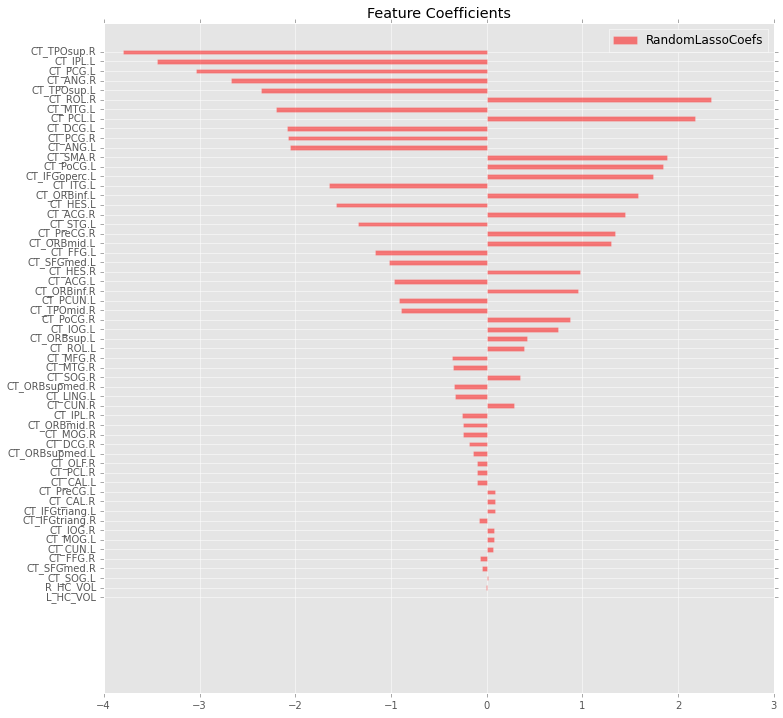

In [108]:
# Pick a classifier, plot the feature weights
K = 76 # K components to visualize
T = 0 # Target clinical scale to visualize

feats = zip(var_names, np.mean(coef_matrix,axis=0))
feats.sort(reverse=False, key=lambda x: abs(x[1]))
feats = [feat for feat in feats if abs(feat[1]) > 0.0]
# Plot the feature importances of the classifier
print '{} Features with non-zero coefficients:'.format(len(feats))
plt.figure()
plt.title("Feature Coefficients")
y_pos = np.arange(len(feats))
plt.barh(y_pos, width=zip(*feats)[1], height=0.5, color='r', align="center", alpha=0.5, label='RandomLassoCoefs')
plt.yticks(y_pos, zip(*feats)[0])
plt.legend()
plt.show()

In [109]:
from sklearn.linear_model import Ridge

# Fit final model for testing
X_tv = np.concatenate([cv_data['X_train'][0], cv_data['X_valid'][0]], axis=0)
y_tv = np.concatenate([cv_data['y_train'][0], cv_data['y_valid'][0]], axis=0)

if BaseReg==linear_model.RidgeCV:
    test_reg = Ridge(alpha=best_alpha, normalize=False, fit_intercept=True)
else:
    test_reg = Regression(normalize=False, fit_intercept=True)

# Feature Select:
X_tv_r = X_tv[:,final_support]#.reshape(X_tv.shape[0],-1)
print X_tv_r.shape
print y_tv.shape

test_reg.fit(X_tv_r, y_tv)

(581, 58)
(581, 1)


In [110]:
X_t = test_data['X']
y_t = test_data['y']

X_t = X_t[:,final_support]
print X_t.shape
print y_t.shape
y_hat_t=test_reg.predict(X_t)
R2 = r2_score(y_t, y_hat_t)
r = scipy.stats.pearsonr(y_t, y_hat_t)
rmse = np.sqrt(mean_squared_error(y_t, y_hat_t))
print rmse

(110, 58)
(110, 1)
0.1819875483
8.31966288727


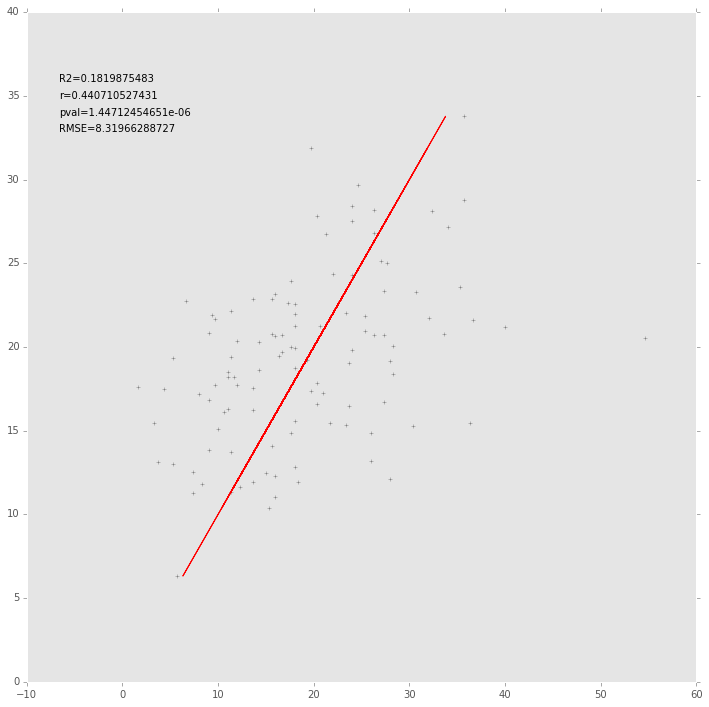

In [116]:
ax=plt.subplot(1,1,1)
plt.scatter(y_t, y_hat_t, marker='+', color='gray')
plt.plot(y_hat_t, y_hat_t, color='red', linewidth=1)
plt.text(0.05, 0.9,'R2={}'.format(R2), horizontalalignment='left', verticalalignment='center', transform = ax.transAxes)
plt.text(0.05, 0.875,'r={}'.format(r[0][0]), horizontalalignment='left', verticalalignment='center', transform = ax.transAxes)
plt.text(0.05, 0.85,'pval={}'.format(r[1][0]), horizontalalignment='left', verticalalignment='center', transform = ax.transAxes)
plt.text(0.05, 0.825,'RMSE={}'.format(rmse), horizontalalignment='left', verticalalignment='center', transform = ax.transAxes)
plt.grid()    
plt.show()